In [15]:
import pandas as pd
#from ydata_profiling import ProfileReport
import numpy as np
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as units
import networkx as nx 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import gaussian_kde
import seaborn as sns
#from rapidfuzz import fuzz

In [2]:
jwst  = pd.read_csv('jwstqueries.csv')

new_df = pd.read_csv('final_resolved_data.csv')

In [ ]:
# Unable to get it working on ipynb, used web version instead

# from ipyaladin import Aladin
# from astropy.table import Table

# aladin = Aladin()

# table = Table.from_pandas(pd.read_csv('foraladin.csv'))
# aladin.add_table(table, shape= 'cross')

# aladin

<Figure size 1500x1000 with 0 Axes>

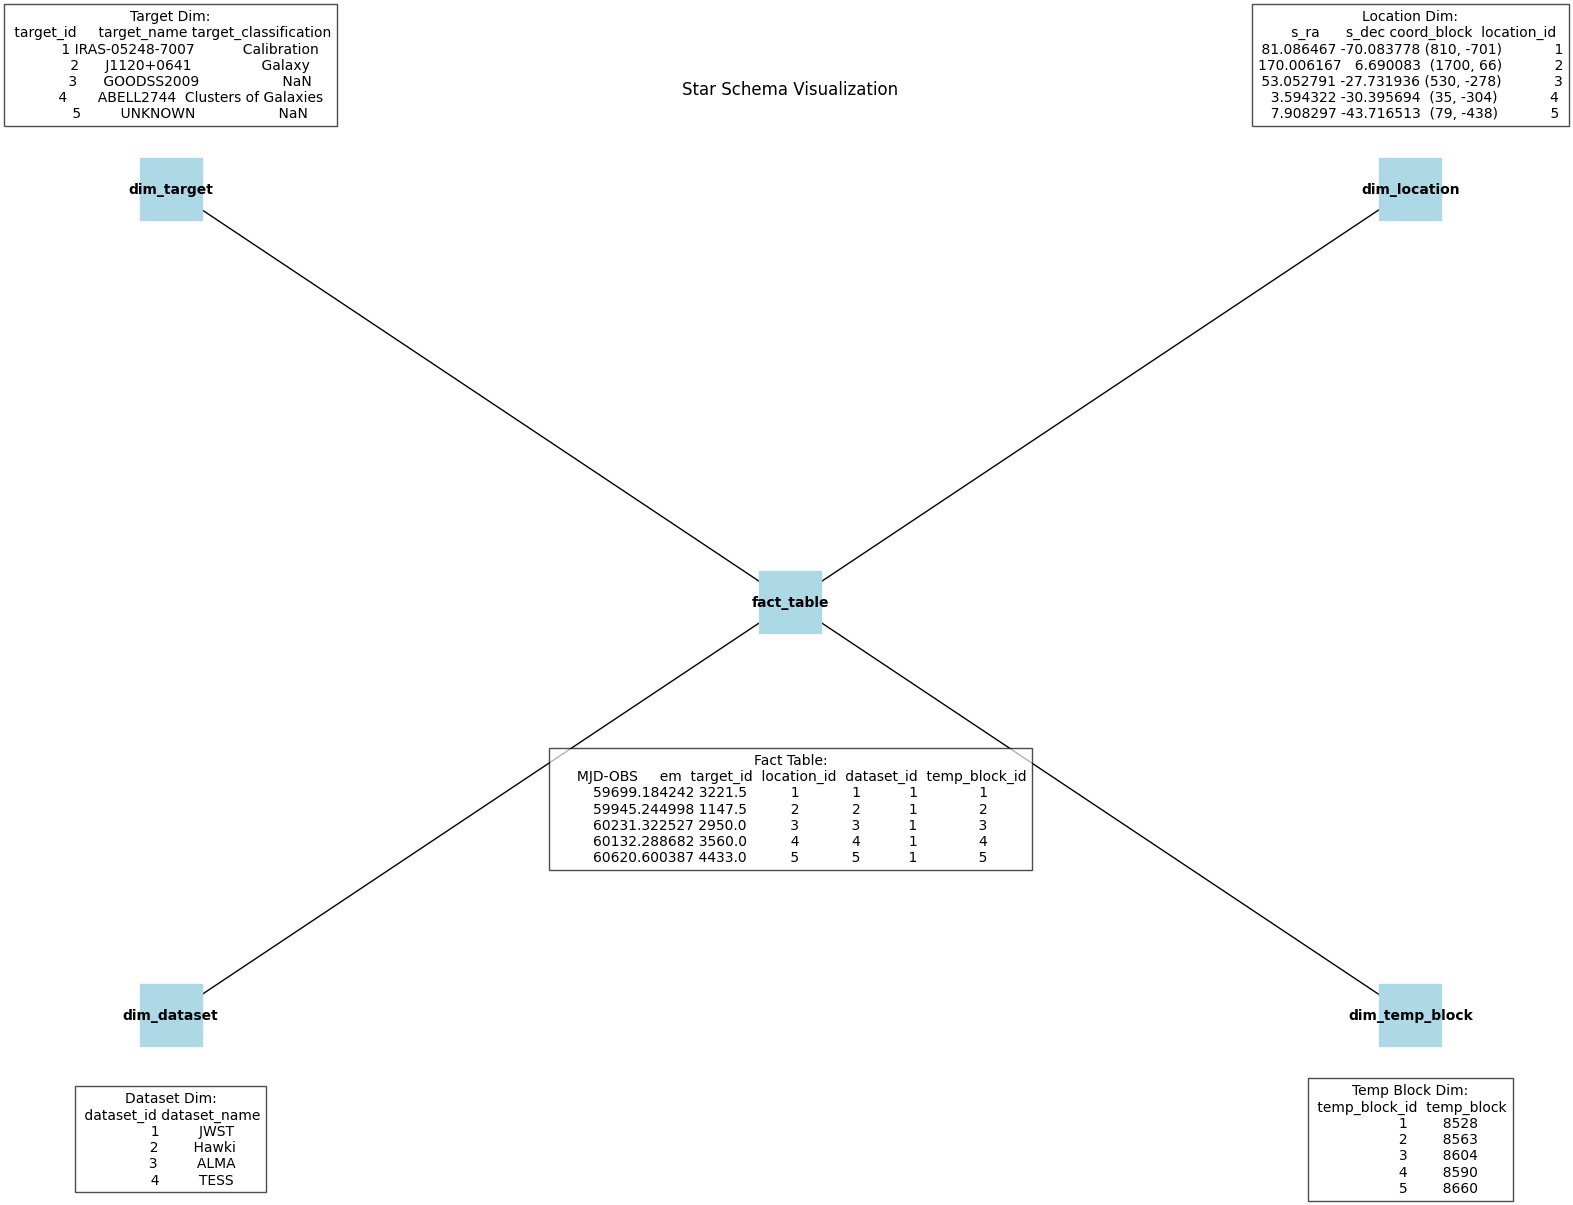

In [39]:
# Create violin plot of MJD-OBS distribution by observatory

# First create the dimension tables as before
target_classification_map = dict(zip(jwst['target_name'], jwst['target_classification']))

dim_target = pd.DataFrame({
    'target_id': range(1, len(new_df['target_name'].drop_duplicates()) + 1),
    'target_name': new_df['target_name'].drop_duplicates(),
})
dim_target['target_classification'] = dim_target['target_name'].map(target_classification_map)
dim_target['target_classification'] = dim_target.target_classification.str.split(';').str[0]

dim_location = new_df[['s_ra', 's_dec', 'coord_block']].drop_duplicates()
dim_location['location_id'] = range(1, len(dim_location) + 1)

dim_dataset = pd.DataFrame({
    'dataset_id': range(1, len(new_df['dataset'].drop_duplicates()) + 1),
    'dataset_name': new_df['dataset'].drop_duplicates()
})

dim_temp_block = pd.DataFrame({
    'temp_block_id': range(1, len(new_df['temp_block'].drop_duplicates()) + 1),
    'temp_block': new_df['temp_block'].drop_duplicates(),
})

# Create fact table
fact_table = pd.DataFrame({
    'MJD-OBS': new_df['MJD-OBS'],
    'em': new_df['em'],
    'target_id': new_df['target_name'].map(
        dict(zip(dim_target['target_name'], dim_target['target_id']))),
    'location_id': new_df.set_index(['s_ra', 's_dec']).index.map(
        dict(zip(dim_location.set_index(['s_ra', 's_dec']).index, dim_location['location_id']))),
    'dataset_id': new_df['dataset'].map(
        dict(zip(dim_dataset['dataset_name'], dim_dataset['dataset_id']))),
    'temp_block_id': new_df['temp_block'].map(
        dict(zip(dim_temp_block['temp_block'], dim_temp_block['temp_block_id']))),
})

# --------------------------------------------------------------------- #

# STAR SCHEMA VISUALIZATION

# Create a figure with a larger size
plt.figure(figsize=(15, 10))

# Create a network graph
G = nx.Graph()

# Add nodes for fact table and dimension tables
G.add_node('fact_table', pos=(0, 0))
G.add_node('dim_target', pos=(-1, 1))
G.add_node('dim_location', pos=(1, 1))
G.add_node('dim_dataset', pos=(-1, -1))
G.add_node('dim_temp_block', pos=(1, -1))

# Add edges connecting fact table to dimension tables
G.add_edge('fact_table', 'dim_target')
G.add_edge('fact_table', 'dim_location')
G.add_edge('fact_table', 'dim_dataset')
G.add_edge('fact_table', 'dim_temp_block')

# Get positions for all nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the network
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=10, font_weight='bold',
        node_shape='s')  # Changed to square nodes

# Add table samples as text
fact_sample = fact_table.head().to_string(index=False)
dim_target_sample = dim_target.head().to_string(index=False)
dim_location_sample = dim_location.head().to_string(index=False)
dim_dataset_sample = dim_dataset.head().to_string(index=False)
dim_temp_block_sample = dim_temp_block.head().to_string(index=False)

# Add text boxes for each table
plt.text(0, -0.5, f'Fact Table:\n{fact_sample}', 
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.text(-1, 1.3, f'Target Dim:\n{dim_target_sample}', 
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.text(1, 1.3, f'Location Dim:\n{dim_location_sample}', 
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.text(-1, -1.3, f'Dataset Dim:\n{dim_dataset_sample}', 
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.text(1, -1.3, f'Temp Block Dim:\n{dim_temp_block_sample}', 
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.title('Star Schema Visualization')
plt.axis('off')
plt.show()

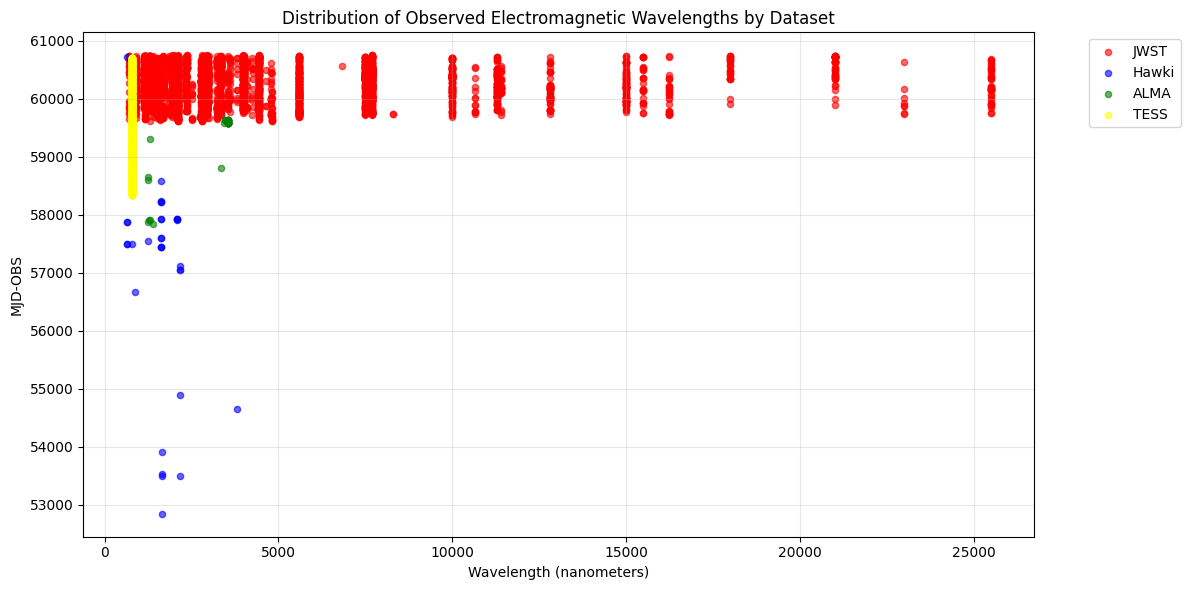

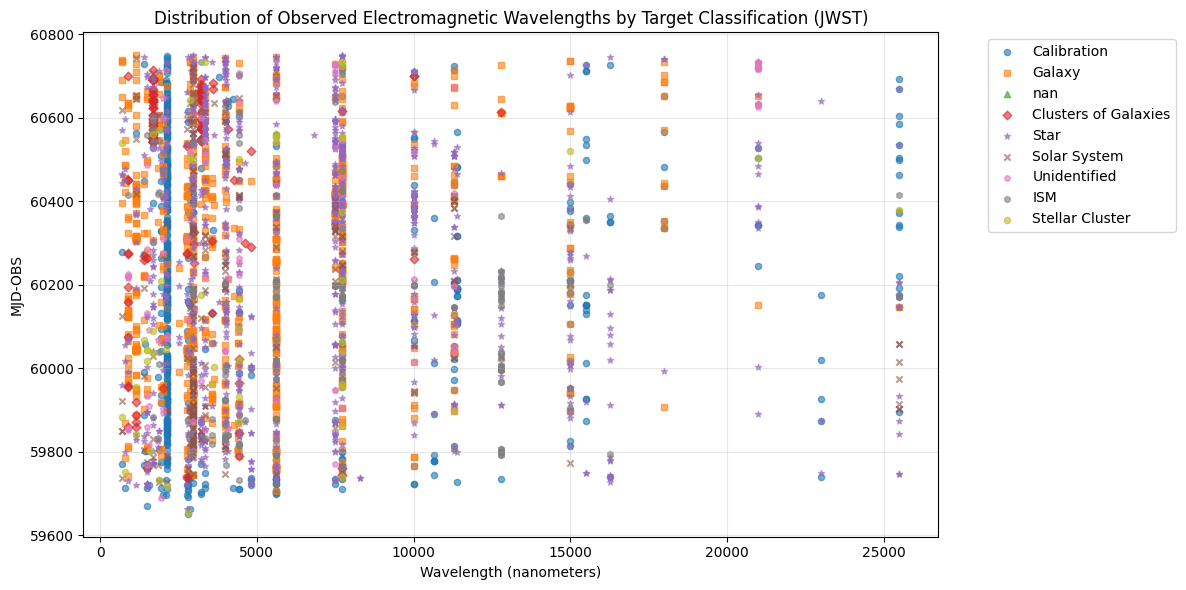

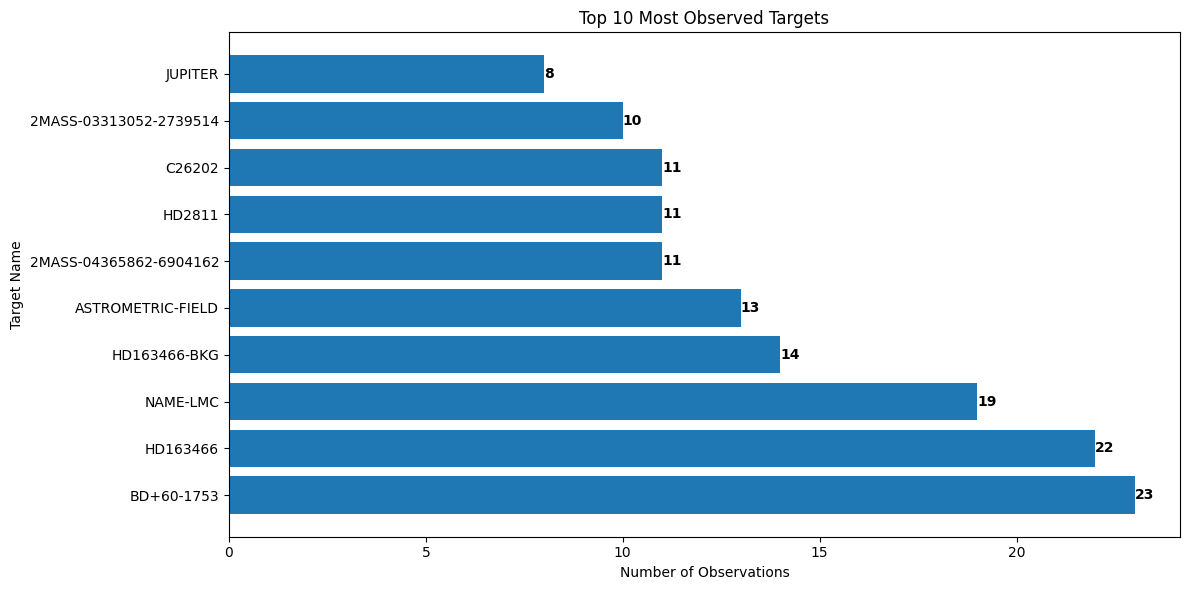

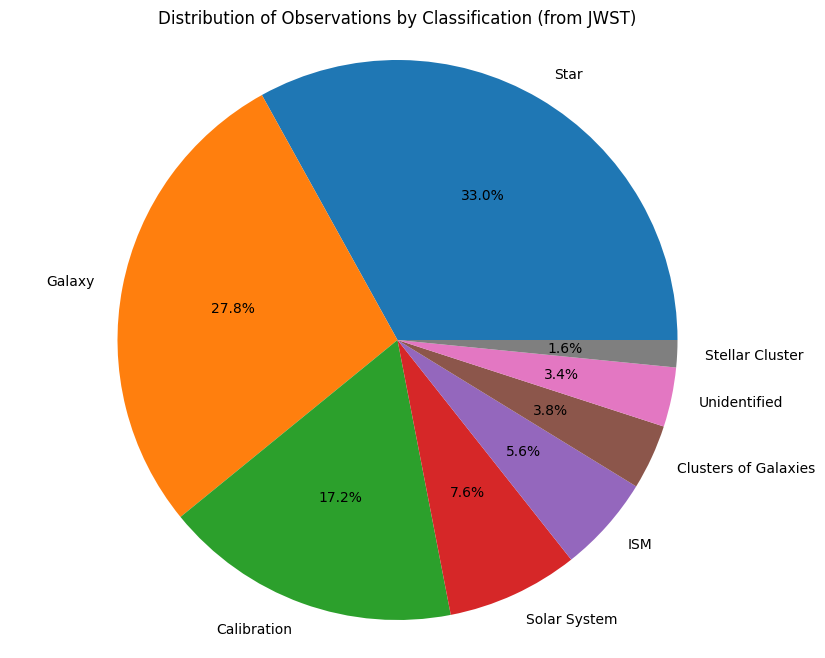

In [40]:
# FOR QUESTIONS

def get_observations_by_name(name):
    df = fact_table.merge(dim_target, on='target_id')
    return df.query(f'target_name == @name').drop(columns=['target_id'])

get_observations_by_name('J1120+0641')

def get_observations_by_name(name):
    df = fact_table.merge(dim_target, on='target_id')
    return df.query(f'target_classification == @name').drop(columns=['target_id'])

get_observations_by_name('Star')

def get_observations_by_location(location):
    df = fact_table.merge(dim_location, on='location_id')
    return df.query(f'coord_block == @location').drop(columns=['location_id'])

get_observations_by_location('(810, -701)')

# --------------------------------------------------------------------- #

# Create scatter plot of observed electromagnetic waves by dataset
plt.figure(figsize=(12, 6))

# Merge fact table with dataset dimension to get wavelength information
wavelength_data = fact_table.merge(dim_dataset, on='dataset_id')

# Create scatter plot with different colors for each dataset
datasets = wavelength_data['dataset_name'].unique()
colors = ['red', 'blue', 'green', 'yellow']  # Fixed colors
dataset_colors = dict(zip(datasets, colors))

# Plot points for each dataset
for dataset in datasets:
    dataset_data = wavelength_data[wavelength_data['dataset_name'] == dataset]
    plt.scatter(dataset_data['em'], 
                dataset_data['MJD-OBS'],
                c=[dataset_colors[dataset]],
                label=dataset,
                alpha=0.6,
                s=20)  # Added s=20 to make dots smaller

plt.title('Distribution of Observed Electromagnetic Wavelengths by Dataset')
plt.xlabel('Wavelength (nanometers)')
plt.ylabel('MJD-OBS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------- #

# Create scatter plot of observed electromagnetic waves by dataset
plt.figure(figsize=(12, 6))

# Merge fact table with dataset and target dimensions to get wavelength and classification information
wavelength_data = fact_table.merge(dim_dataset, on='dataset_id').merge(dim_target, on='target_id')

# Filter for JWST data only
wavelength_data = wavelength_data[wavelength_data['dataset_name'].str.contains('JWST')]

# Create scatter plot with different markers for each target classification
classifications = wavelength_data['target_classification'].unique()
markers = ['o', 's', '^', 'D', '*', 'x', 'p', 'h']  # Different marker shapes
classification_markers = {cls: markers[i % len(markers)] for i, cls in enumerate(classifications)}

# Plot points for each classification
for classification in classifications:
    class_data = wavelength_data[wavelength_data['target_classification'] == classification]
    plt.scatter(class_data['em'], 
                class_data['MJD-OBS'],
                marker=classification_markers[classification],
                label=classification,
                alpha=0.6,
                s=20)

plt.title('Distribution of Observed Electromagnetic Wavelengths by Target Classification (JWST)')
plt.xlabel('Wavelength (nanometers)')
plt.ylabel('MJD-OBS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------- #

# Get the most common target names and their observation counts
target_counts = fact_table.merge(dim_target, on='target_id')['target_name'].value_counts()
# Filter out TESS FFI and UNKNOWN
target_counts = target_counts[~target_counts.index.isin(['TESS FFI', 'UNKNOWN'])].head(10)

# Create a horizontal bar plot
plt.figure(figsize=(12, 6))
bars = plt.barh(target_counts.index, target_counts.values)

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             ha='left', va='center', fontweight='bold')

plt.title('Top 10 Most Observed Targets')
plt.xlabel('Number of Observations')
plt.ylabel('Target Name')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------- #

# PIE PLOT FOR CLASSIFICATION
classification_counts = fact_table.merge(dim_target, on='target_id')['target_classification'].value_counts()
# Create pie plot
plt.figure(figsize=(10, 8))
plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Observations by Classification (from JWST)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

